<h1><center>ML DSL in Action</center></h1>

Google Cloud Platform: 
1. Google Dataproc
2. Google Cloud Storage
3. Google AI Platform

In [1]:
import com.griddynamics.dsl.ml.mldsl as mldsl
from com.griddynamics.dsl.ml.settings.profiles import PySparkJobProfile, Profile
from com.griddynamics.dsl.ml.settings.description import Platform

import importlib
import os
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Prepare Sequences from Original Text

### Text Sample

In [2]:
!head -n 20 dev/aclImdb/test/pos/0_10.txt

I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

### Tokenizer to Create Sequences 

### Execute Tokenizer on ML Platform

In [104]:
%py_script_open -n ml_text_tokenizer.py -p demo/scripts -o dev

Temporary path: /home/jovyan/work/data/.mldsl/ml_text_tokenizer.py


In [4]:
platform = Platform.GCP
profile = PySparkJobProfile(root_path='/home/jovyan/work/data/demo/scripts',
                                  bucket='ai4ops',
                                  project='gd-gcp-techlead-experiments',
                                  cluster='ai4ops',
                                  region='global',
                                  ai_region='us-central1',
                                  job_prefix='demo_job',
                                  job_async=False,
                           )
profile.args={"--train_pos_path": "gs://ai4ops/mldsl/data/aclImdb/train/pos",
              "--train_neg_path": "gs://ai4ops/mldsl/data/aclImdb/train/neg",
              "--test_pos_path": "gs://ai4ops/mldsl/data/aclImdb/test/pos",
              "--test_neg_path": "gs://ai4ops/mldsl/data/aclImdb/test/neg",
              "--max_seq": "500",
              "--word_embeds": "gs://ai4ops/mldsl/data/glove.6B.50d.txt"}
Profile.set('CreateSequencesProfile', profile)

In [5]:
%py_data -n ml_text_tokenizer.py -p CreateSequencesProfile -pm $platform -o gs://ai4ops/mldsl/data

Parameters string = <<<-n ml_text_tokenizer.py -p CreateSequencesProfile -pm 1 -o gs://ai4ops/mldsl/data>>>


Job with id demo_job_1586421552 was submitted to the cluster ai4ops
Job STATUS was set to DONE at 2020-04-09 09:16:55


<IPython.core.display.JSON object>

In [ ]:
#Use job_demo_job_1586421552 instance to browse job properties.
#job_demo_job_1586421552 = job_tracker['demo_job_1586421552']

### Reading logs of dataproc job

In [6]:
project_id = "gd-gcp-techlead-experiments"

filters = """resource.type:cloud_dataproc_cluster
AND timestamp>2020-02-16
AND resource.labels.cluster_name:ai4ops 
AND jsonPayload.application:application_1570197709805_0110"""

In [7]:
#%logging -p $project_id -f $filters

# ML Model to Predict Positive or Negative Review

### Configure Additional Dependencies

### LSTM Train Script

In [129]:
%%py_script -e -n mr_model.py -p demo/model/words/trainer -o ./dev/models --epochs 30 --train_path gs://ai4ops/mldsl/data/demo_job_1586421552/train --word_embeds gs://ai4ops/mldsl/data/demo_job_1586421552/words --seq_len 200
#!/usr/bin/python

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import pandas as pd
    import numpy as np
    from tensorflow.python.lib.io import file_io
    from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import Callback
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    from tensorflow.core.protobuf import rewriter_config_pb2
    from tensorflow.keras.backend import set_session
    tf.keras.backend.clear_session()  # For easy reset of notebook state.

    from uuid import uuid4
    import argparse
    import matplotlib
    if matplotlib.get_backend() in ['TkAgg', 'TkCairo']:
        matplotlib.use('agg')
    import matplotlib.pyplot as plt
    import seaborn as sns


class MetricCallback(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))


def read_glove_vectors(glove_file):
    files = file_io.get_matching_files('{}/part*'.format(glove_file))
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            word_to_vec_map = {}
            words_to_index = {}
        fl = f.readline()
        for line in f:
            line = line.strip().split('\t')
            word_to_vec_map[line[0]] = np.array(line[1].split(','), dtype=np.float64)
            words_to_index[line[0]] = int(line[2])
    return words_to_index, word_to_vec_map


def read_csv(path):
    files = file_io.get_matching_files('{}/part*'.format(path))
    pdf = []
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            df = pd.read_csv(f)
            if df is not None and len(df) != 0:
                pdf.append(df)
    if len(pdf) == 0:
        return None
    return pd.concat(pdf, axis=0, ignore_index=True).reset_index()


def pretrained_embed_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(input_dim=vocab_len, trainable=False, output_dim=emb_dim)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer


def define_model(input_shape, word_to_vec_map, word_to_index, rnn_units, dropout=0.5):
    sentence_indices = Input(input_shape, dtype="int32")
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embed_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    X = LSTM(units=rnn_units, return_sequences=False)(embeddings)
    # Add dropout with a probability 
    X = Dropout(dropout)(X)
    # Propagate X through a Dense layer
    X = Dense(2)(X)
    # Add a softmax activation
    X = Activation("softmax")(X)
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    return model


def convert_to_one_hot(Y, C=2):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def prepare_dataset(path, N, word_to_index):
    data = read_csv(path)
    data.dropna(inplace=True)
    data['int_seq'] = data['int_seq'].apply(lambda x: [int(i) for i in x.split(',')])
    l = data['int_seq'].apply(lambda x: len(x))
    print("Max sequence is set to {}".format(N))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x + [word_to_index["unk"]] * N)[:N])
    ds_x = np.asarray(list(data["int_seq"]))
    ds_y = data["class"].values
    return ds_x, ds_y, l


def plot_metrics(callback, dir_to_save):
    f, axes = plt.subplots(1, 2, figsize=(18, 5))
    plt.style.use('seaborn')
    plt.rcParams['axes.titlesize'] = 16
    sns.lineplot(x=range(len(callback.losses)), y=callback.losses, ax=axes[0])
    axes[0].title.set_text("Loss")
    sns.lineplot(x=range(len(callback.accuracies)), y=callback.accuracies, ax=axes[1])
    axes[1].title.set_text("Accuracy")
    plt.tight_layout(.5)
    plt.savefig('{}'.format(dir_to_save))
    plt.show()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_path', type=str, help="Train files path")
    parser.add_argument('--output_path', type=str, help="Models output path")
    parser.add_argument('--word_embeds', type=str, help="Models output path")
    parser.add_argument('--seq_len', type=int, help="Length of input sequence")
    parser.add_argument('--epochs', type=int, help="Number of epochs")
    args, d = parser.parse_known_args()

    word_to_index, word_to_vec_map = read_glove_vectors(args.word_embeds)
    N = args.seq_len
    train_x, train_y, l = prepare_dataset(args.train_path, N, word_to_index)
    train_y = convert_to_one_hot(train_y, C=2)
    NUM_EPOCS = args.epochs
    RNN_STATE_DIM = 32
    LEARNING_RATE = 0.01

    config_proto = tf.ConfigProto()
    off = rewriter_config_pb2.RewriterConfig.OFF
    config_proto.graph_options.rewrite_options.arithmetic_optimization = off
    session = tf.Session(config=config_proto)
    set_session(session)

    model = define_model((N, ), word_to_vec_map, word_to_index, RNN_STATE_DIM)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    # fit model
    metrics = MetricCallback()
    a = model.fit(train_x, train_y, batch_size=1024, epochs=NUM_EPOCS, callbacks=[metrics], shuffle=True)

    # save the model to file
    local_dir = uuid4().hex
    file_io.recursive_create_dir(local_dir)
    local_path = '{}'.format(local_dir)
    model.save(local_path, save_format='tf')
    local_path_chart = '{}/metrics.png'.format(local_dir)
    plot_metrics(metrics, local_path_chart)
    
    remote_dir = args.output_path
    remote_path = '{}/saved_model.h5'.format(remote_dir)
    remote_path_chart = '{}/metrics.png'.format(remote_dir)
    
    if not remote_dir.startswith('gs://'):
        file_io.recursive_create_dir(remote_dir)
    file_io.copy(local_path, remote_path)
    file_io.copy(local_path_chart, remote_path_chart)
    file_io.delete_recursively(local_dir)    


Max sequence is set to 200
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 50)           20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                10624     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 20,010,740
Trainable params: 10,690
Non-trainable params: 20,000,050
_________________

## Prediction

In [131]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from tensorflow.python.lib.io import file_io
    import pandas as pd
    import numpy as np

df_x, df_y, l = prepare_dataset('gs://ai4ops/mldsl/data/demo_job_1586421552/test', 200, word_to_index)

ints = np.random.choice(len(df_y), 200)

test_x = df_x[ints]
test_y = df_y[ints]
test = test_x.tolist()

dense=model.predict(test_x)
dense=(dense[:,0]<dense[:,1]).astype(int)

Max sequence is set to 200


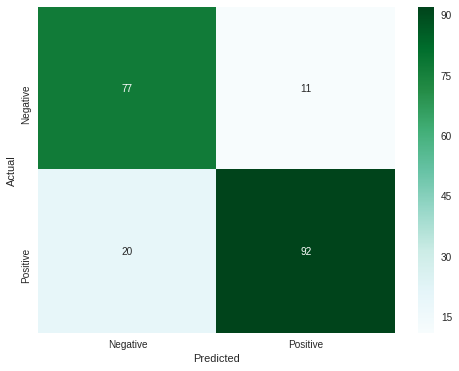

In [132]:
conf_mat = confusion_matrix(test_y, dense)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [133]:
classification_report(test_y, dense,output_dict=True)

{'0': {'precision': 0.7938144329896907,
  'recall': 0.875,
  'f1-score': 0.8324324324324325,
  'support': 88},
 '1': {'precision': 0.8932038834951457,
  'recall': 0.8214285714285714,
  'f1-score': 0.8558139534883721,
  'support': 112},
 'accuracy': 0.845,
 'macro avg': {'precision': 0.8435091582424181,
  'recall': 0.8482142857142857,
  'f1-score': 0.8441231929604023,
  'support': 200},
 'weighted avg': {'precision': 0.8494725252727454,
  'recall': 0.845,
  'f1-score': 0.8455260842237586,
  'support': 200}}